## Project Introduction

In this project, we seek to use LLMs to translate phrases from foreign languages to English and compare them with the translation found within the dataset to ascertain the accuracy of LLM translations. We begin by loading datasets containing sentences in foreign languages along with their english counterparts. We then perform exploratory data analysis on these datasets to examine their contents.

LLMs are then used to translate the foreign language sentences, and the quality of these translations are then assessed by calculating the BLEU Score with the english translation from the dataset used as reference.

In doing this, we hope to identify the strengths and weaknesses of LLM translations and we seek to identify how to make LLM translations more accurate.

## Data Preparation

In [ ]:
! pip install sacrebleu

In [3]:
import requests
import pandas as pd
import time

from datasets import load_dataset

from huggingface_hub import notebook_login
from huggingface_hub import HfFolder
from huggingface_hub import InferenceApi

import sacrebleu

import matplotlib.pyplot as plt

In [ ]:
dataset = load_dataset("mt_eng_vietnamese", 'iwslt2015-en-vi')

Found cached dataset mt_eng_vietnamese (C:/Users/Snehitha Chowdary/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-en-vi/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71)


  0%|          | 0/3 [00:00<?, ?it/s]

### Retreiving Vietnamese-English Dataset

In [ ]:
train_data = dataset["train"]
validation_data = dataset['validation']
test_data = dataset['test']

# Extract English and Vietnamese translations
english_translations = [sample['translation']['en'] for sample in train_data]
vietnamese_translations = [sample['translation']['vi'] for sample in train_data]

# Create DataFrame
df = pd.DataFrame({'English': english_translations, 'Vietnamese': vietnamese_translations})

print(df.head())

                                             English  \
0  Rachel Pike : The science behind a climate hea...   
1  In 4 minutes , atmospheric chemist Rachel Pike...   
2  I &apos;d like to talk to you today about the ...   
3  Headlines that look like this when they have t...   
4  They are both two branches of the same field o...   

                                          Vietnamese  
0           Khoa học đằng sau một tiêu đề về khí hậu  
1  Trong 4 phút , chuyên gia hoá học khí quyển Ra...  
2  Tôi muốn cho các bạn biết về sự to lớn của nhữ...  
3  Có những dòng trông như thế này khi bàn về biế...  
4  Cả hai đều là một nhánh của cùng một lĩnh vực ...  


### Retreiving French-English Dataset

In [4]:
french_dataset = load_dataset("demelin/wino_x", 'lm_en_fr')

Generating test split:   0%|          | 0/2793 [00:00<?, ? examples/s]

In [5]:
test_data = french_dataset['test']

english_translations = [sample['context_en'] for sample in test_data]
french_translations = [sample['context_fr'] for sample in test_data]

# Create DataFrame
fr_df = pd.DataFrame({'English': english_translations, 'French': french_translations})

fr_df = fr_df[fr_df.index % 2 == 0]
fr_df = fr_df[:298]
display(fr_df)

,English,French
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...
6,Joe got into the school but not into the Unive...,Joe est entré à l' école mais pas à l' univers...
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l' ...
...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois de loin supér..."
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de root beer et voula...


### Setting up Bloom API for Translation

In [ ]:
#enter your API key, you can make one for free on HF
notebook_login()

In [6]:
inference = InferenceApi("bigscience/bloom",token=HfFolder.get_token())

def infer(prompt,
          max_length,
          top_k = 0,
          num_beams = 0,
          no_repeat_ngram_size = 2,
          top_p = 0.9,
          seed=42,
          temperature=0.7,
          greedy_decoding = False,
          return_full_text = False):


    top_k = None if top_k == 0 else top_k
    do_sample = False if num_beams > 0 else not greedy_decoding
    num_beams = None if (greedy_decoding or num_beams == 0) else num_beams
    no_repeat_ngram_size = None if num_beams is None else no_repeat_ngram_size
    top_p = None if num_beams else top_p
    early_stopping = None if num_beams is None else num_beams > 0

    params = {
        "max_new_tokens": max_length,
        "top_k": top_k,
        "top_p": top_p,
        "temperature": temperature,
        "do_sample": do_sample,
        "seed": seed,
        "early_stopping":early_stopping,
        "no_repeat_ngram_size":no_repeat_ngram_size,
        "num_beams":num_beams,
        "return_full_text":return_full_text
    }

    s = time.time()
    response = inference(prompt, params=params)
    #print(response)
    proc_time = time.time()-s
    #print(f"Processing time was {proc_time} seconds")
    return response

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'InferenceApi' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


## Exploratory Data Analysis

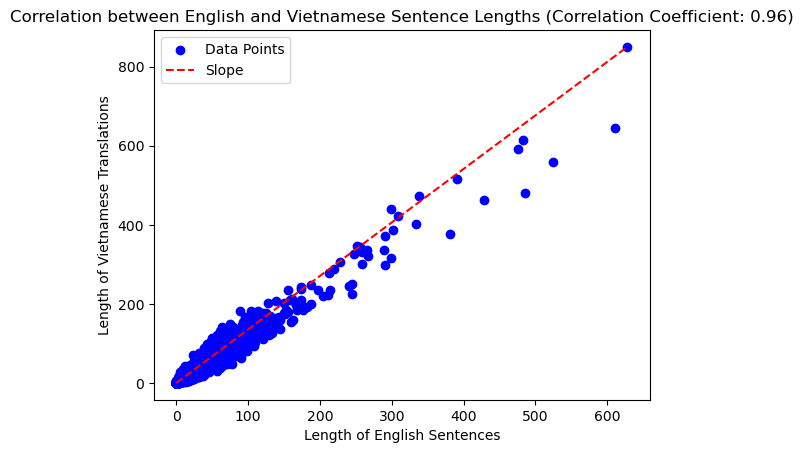

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate lengths and add them as new columns to the DataFrame
English_Length= df['English'].apply(lambda x: len(x.split()))
Vietnamese_Length= df['Vietnamese'].apply(lambda x: len(x.split()))

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(English_Length, Vietnamese_Length)[0, 1]

# Scatter plot with different colors for each point
plt.scatter(English_Length, Vietnamese_Length, c='blue', label='Data Points')

# Plot a line representing the slope of the correlation
plt.plot([min(English_Length), max(English_Length)], [min(Vietnamese_Length), max(Vietnamese_Length)], color='red', linestyle='--', label='Slope')

plt.xlabel('Length of English Sentences')
plt.ylabel('Length of Vietnamese Translations')
plt.title('Correlation between English and Vietnamese Sentence Lengths (Correlation Coefficient: {:.2f})'.format(correlation_coefficient))
plt.legend()
plt.show()

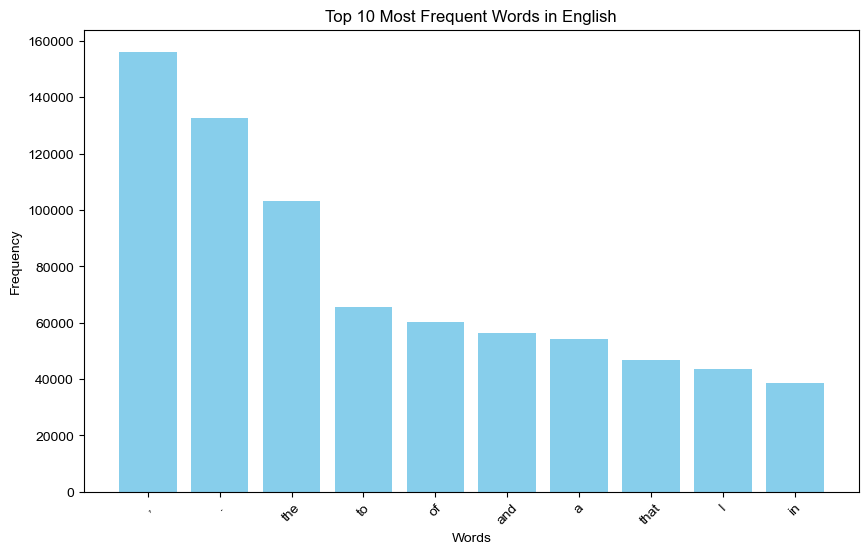

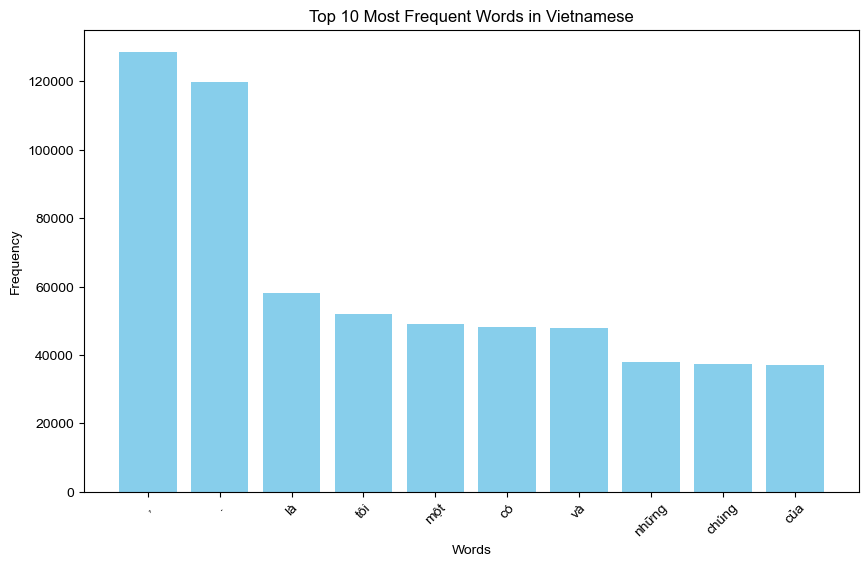

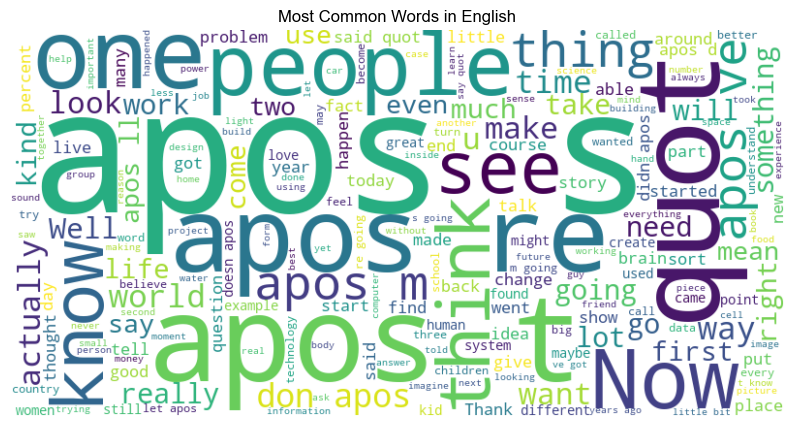

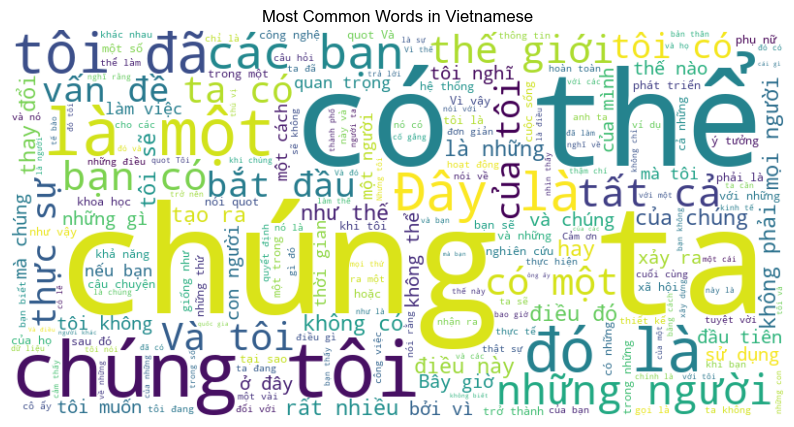

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Set the font globally for matplotlib
plt.rcParams['font.family'] = 'Arial'

# Preprocess data to get all English and Vietnamese words
english_words = [word for text in df['English'] for word in text.split()]
vietnamese_words = [word for text in df['Vietnamese'] for word in text.split()]

# Visualization 1: Bar plot - Top N most frequent words
def plot_top_words(word_list, language, top_n=10):
    word_counts = Counter(word_list)
    top_words = word_counts.most_common(top_n)
    plt.figure(figsize=(10, 6))
    plt.bar([word[0] for word in top_words], [count[1] for count in top_words], color='skyblue')
    plt.title(f'Top {top_n} Most Frequent Words in {language}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(english_words, 'English', top_n=10)
plot_top_words(vietnamese_words, 'Vietnamese', top_n=10)

# Visualization 2: Word cloud
def generate_wordcloud(word_list, language):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {language}')
    plt.axis('off')
    plt.show()

generate_wordcloud(english_words, 'English')
generate_wordcloud(vietnamese_words, 'Vietnamese')


C:\Users\Snehitha Chowdary\AppData\Local\Temp\ipykernel_9728\966023067.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(english_sentiments, shade=True, color="b", label="English")
C:\Users\Snehitha Chowdary\AppData\Local\Temp\ipykernel_9728\966023067.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(french_sentiments, shade=True, color="r", label="French")


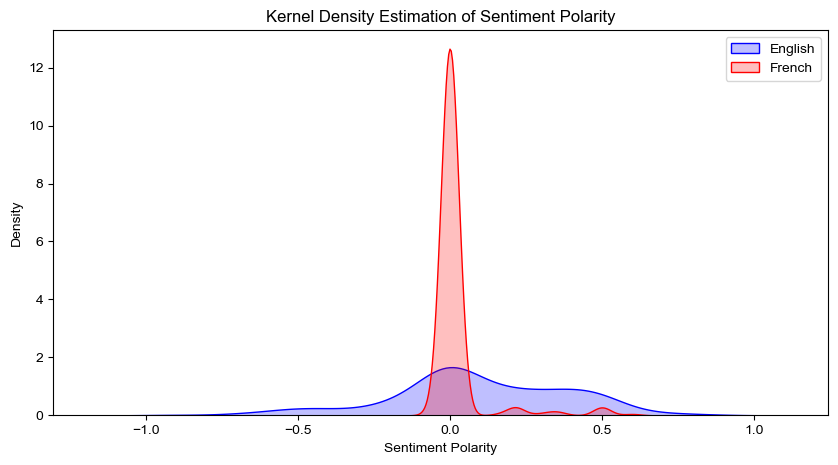

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd


# Calculate sentiment polarity for English and French translations
english_sentiments = [TextBlob(text).sentiment.polarity for text in fr_df['English']]
french_sentiments = [TextBlob(text).sentiment.polarity for text in fr_df['French']]

# Set up the figure and axis
plt.figure(figsize=(10, 5))

# Create KDE plots for English and French sentiment distributions
sns.kdeplot(english_sentiments, shade=True, color="b", label="English")
sns.kdeplot(french_sentiments, shade=True, color="r", label="French")

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Sentiment Polarity')

# Add legend
plt.legend()

# Show the plot
plt.show()



#### Hypothesis 4 - Word overlaps between English and French translations

Snehitha Chowdary Pallinti-The above visualization is performed by first loading the dataset and extracting their translations. The translations obtained are split into words of two sets english_words and french_words. These sets contain unique words from english and French translations respectively. Now create a venn diagram using venn2 function from matplotlib_venn library. This venn diagram visualizes the overlap between the two sets of words. The  number of words that are common to both english and French translations are represented at the intersection part of diagram. The left circle is for English and right is for French.
The intersection can provide insights into dataset such as the extent of cognates between both languages, number of loanwords, similarity of the vocabulary usend in translations. I found this hypothesis interesting as it is useful for understanding the extent of shared vocabulary between English and French translations in dataset.


Found cached dataset wino_x (C:/Users/Snehitha Chowdary/.cache/huggingface/datasets/demelin___wino_x/lm_en_fr/1.1.0/0c96a2d6dd4a901c5794f2509e79a42084e3381e4780504ac3cb4149ef7a5391)


  0%|          | 0/1 [00:00<?, ?it/s]

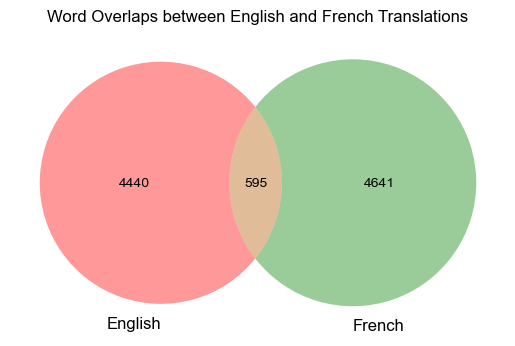

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
from datasets import load_dataset

# Load the dataset
french_dataset = load_dataset("demelin/wino_x", 'lm_en_fr')
test_data = french_dataset['test']

# Extract English and French translations
english_translations = [sample['context_en'] for sample in test_data]
french_translations = [sample['context_fr'] for sample in test_data]

# Create DataFrame
fr_df = pd.DataFrame({'English': english_translations, 'French': french_translations})

# Only select every other row to avoid long runtimes due to large data
fr_df = fr_df.iloc[::2]

# Split the English and French translations into sets of words
english_words = set(" ".join(fr_df['English']).split())
french_words = set(" ".join(fr_df['French']).split())

# Create a Venn diagram to visualize word overlaps
venn2(subsets=(len(english_words), len(french_words), len(english_words.intersection(french_words))),
      set_labels=('English', 'French'))

plt.title('Word Overlaps between English and French Translations')
plt.show()


#### Hypothesis 5 - Parts of speech distribution of English and Vietnamese languages

Snehitha Chowdary Pallinti-A visualization is made based on parts of speech distribution of english and Vietnamese languages from dataset. Firstly libraries are imported and dataset is loaded. Access the dataset and extract sentences from dataset. Perform POS tagging using NLTK library for english and underthesea for Vietnamese. Use a counter to count the frequency of each POS tag in english and Vietnamese POS tag lists obtained. Plot of POS tag distribution for English and Vietnamese are generated. I found this hypothesis interesting as it can be useful for comparing the linguistic structure of the two languages or for analyzing the dataset for machine translation tasks.

[nltk_data] Downloading package punkt to C:\Users\Snehitha
[nltk_data]     Chowdary\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Snehitha
[nltk_data]     Chowdary\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Found cached dataset mt_eng_vietnamese (C:/Users/Snehitha Chowdary/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-en-vi/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71)


  0%|          | 0/3 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



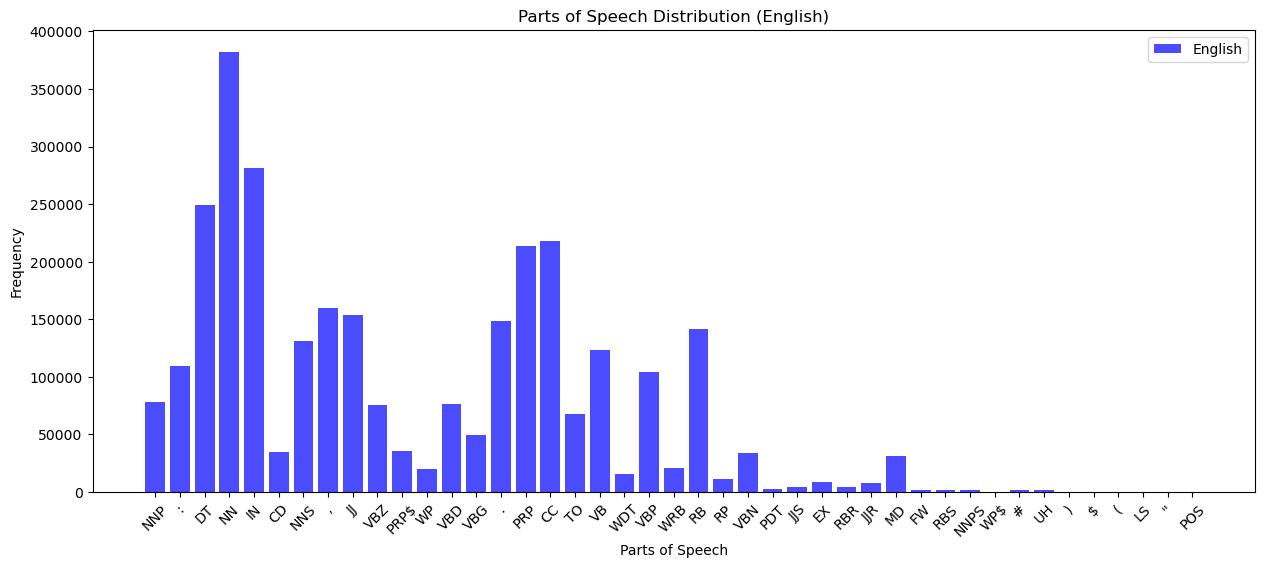

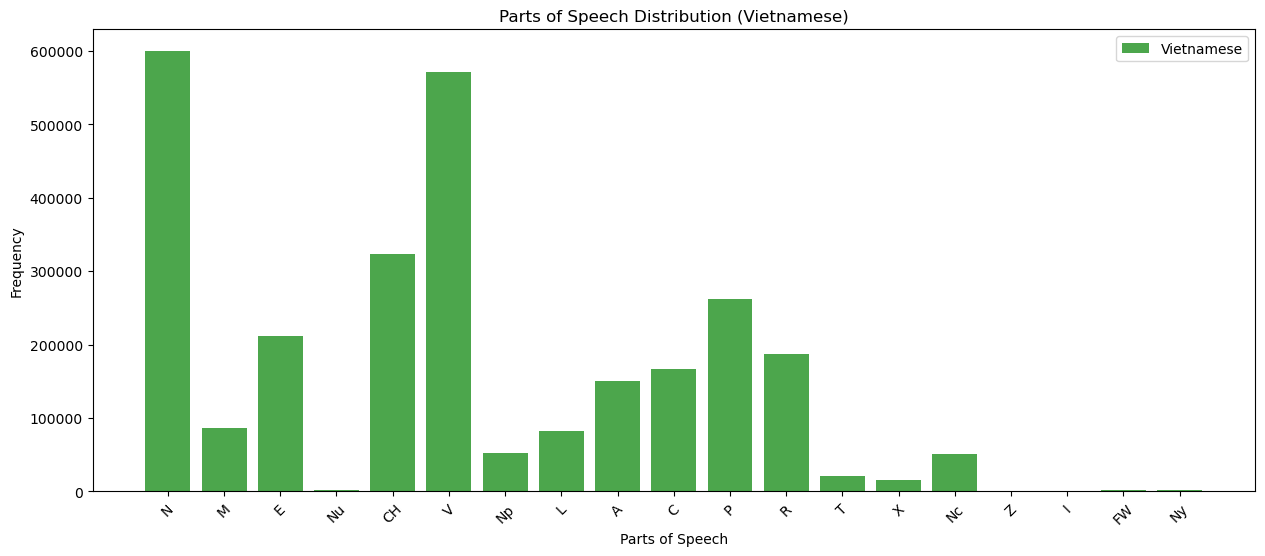

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from underthesea import pos_tag as pos_tag_vn
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load the dataset
from datasets import load_dataset
dataset = load_dataset("mt_eng_vietnamese", "iwslt2015-en-vi")

# Accessing the dataset
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Get English and Vietnamese sentences from train, validation, and test sets
english_sentences = []
vietnamese_sentences = []

# Helper function to extract sentences
def extract_sentences(data_split):
    for data in data_split:
        english_sentences.append(data["translation"]["en"])
        vietnamese_sentences.append(data["translation"]["vi"])

# Extract sentences from all splits
extract_sentences(train_dataset)
extract_sentences(validation_dataset)
extract_sentences(test_dataset)

# Function to tokenize and POS tag sentences
from underthesea import pos_tag as pos_tag_vn
def get_pos_tags(sentences, language='english'):
    pos_tags = []
    for sentence in sentences:
        if language == 'english':
            tokens = word_tokenize(sentence)
            pos_tags.extend(pos_tag(tokens))
        elif language == 'vietnamese':
            pos_tags.extend(pos_tag_vn(sentence))
    return pos_tags

# Get POS tags for English sentences
english_pos_tags = get_pos_tags(english_sentences, 'english')
print(english_pos_tags)

# Get POS tags for Vietnamese sentences
vietnamese_pos_tags = get_pos_tags(vietnamese_sentences, 'vietnamese')

# Count POS tags for English
english_pos_counts = Counter(tag for word, tag in english_pos_tags)

# Count POS tags for Vietnamese
vietnamese_pos_counts = Counter(tag for word, tag in vietnamese_pos_tags)

# Plot POS tag distribution for English
plt.figure(figsize=(15, 6))
plt.bar(english_pos_counts.keys(), english_pos_counts.values(), color='blue', alpha=0.7, label='English')
plt.title('Parts of Speech Distribution (English)')
plt.xlabel('Parts of Speech')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot POS tag distribution for Vietnamese
plt.figure(figsize=(15, 6))
plt.bar(vietnamese_pos_counts.keys(), vietnamese_pos_counts.values(), color='green', alpha=0.7, label='Vietnamese')
plt.title('Parts of Speech Distribution (Vietnamese)')
plt.xlabel('Parts of Speech')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## ML Analysis

### mBart 50 many to many BLEU score

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import load_dataset, load_metric
import sacrebleu

/Users/grishmant/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
dataset = load_dataset("../mt_eng_vietnamese.py", "iwslt2015-vi-en", trust_remote_code=True, split="train")

In [ ]:
source_texts = [example["en"] for example in dataset['translation']]
target_texts = [example["vi"] for example in dataset['translation']]

source_encodings = tokenizer(source_texts, max_length=1024, padding=True, truncation=True, return_tensors="pt")
target_encodings = tokenizer(target_texts, max_length=1024, padding=True, truncation=True, return_tensors="pt")

source_lang = "en_XX"
target_lang = "vi_VN"

In [ ]:
# Example input and output from english to vietnamese

example_input = "Hello, how are you?"

input_ids = tokenizer.encode(example_input, return_tensors="pt")

output_ids = model.generate(input_ids, forced_bos_token_id=tokenizer.lang_code_to_id[target_lang])


translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Input: {example_input}")
print(f"Translation: {translation}")

Input: Hello, how are you?
Translation: Xin chào, mọi chuyện như thế nào?


In [ ]:
import sacrebleu

bleu_metric = load_metric("sacrebleu")

predictions = []
references = []
bleu_scores = []

pred_size, counter = 10, 0

for example in dataset["translation"]:
    input_ids = tokenizer.encode(example["en"], return_tensors="pt")
    output_ids = model.generate(input_ids, forced_bos_token_id=tokenizer.lang_code_to_id[target_lang])
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    reference = example["vi"]

    predictions.append(prediction)
    references.append([reference])

    # Calculate bleu score for the current sentence pair
    bleu_score = sacrebleu.corpus_bleu([prediction], [[reference]]).score

    bleu_scores.append(bleu_score)

    counter += 1
    if counter == pred_size: break

# Calculate overall BLEU score
overall_bleu_score = bleu_metric.compute(predictions=predictions, references=references)
print(f"BLEU score: {overall_bleu_score['score']}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


BLEU score: 39.44300501309953


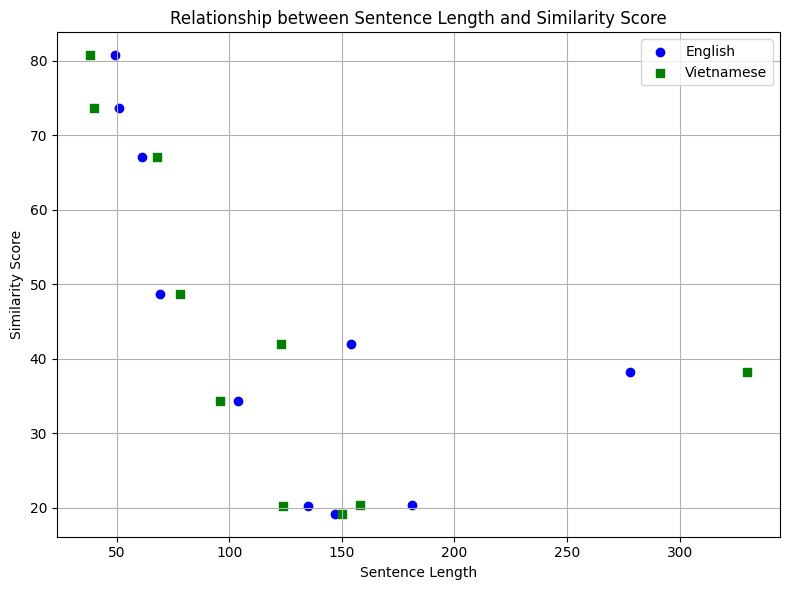

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Calculate length of each sentence
english_lengths = [len(sentence['en']) for sentence in dataset['translation']]
vietnamese_lengths = [len(sentence['vi']) for sentence in dataset['translation']]


plt.figure(figsize=(8, 6))
plt.scatter(english_lengths[:pred_size], bleu_scores, label='English', color='blue', marker='o')
plt.scatter(vietnamese_lengths[:pred_size], bleu_scores, label='Vietnamese', color='green', marker='s')


plt.xlabel('Sentence Length')
plt.ylabel('Similarity Score')
plt.title('Relationship between Sentence Length and Similarity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Translating French Dataset

In [7]:
# Function to apply infer() to each row and return the output
def apply_infer(row):
    output = infer(f"French: {row['French']} English:", len(row['English'].split()) + 3)
    return output

fr_df['LLM_Translation'] = fr_df.apply(apply_infer, axis=1)

# Print the DataFrame with the new 'OutputColumn'
display(fr_df)

,English,French,LLM_Translation
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...,[{'generated_text': ' The woman wanted a diffe...
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...,[{'generated_text': ' The song took longer to ...
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...,[{'generated_text': ' Sergey liked the complex...
6,Joe got into the school but not into the Unive...,Joe est entré à l' école mais pas à l' univers...,[{'generated_text': ' Joe entered the school b...
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l' ...,[{'generated_text': ' Online security was impo...
...,...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...,[{'generated_text': ' The gangster tried to pu...
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...,[{'generated_text': ' His razor could not shav...
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois de loin supér...",[{'generated_text': ' I think oak is a far sup...
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de root beer et voula...,[{'generated_text': ' Piper made a big batch o...


In [8]:
fr_df['LLM_Translation'] = [element[0]['generated_text'] for element in fr_df['LLM_Translation']]
display(fr_df)

,English,French,LLM_Translation
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...,\nThe woman wanted a different vase for the bo...
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...,The song took longer to sing than the ballad ...
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...,Sergey liked the complex drawings and decided...
6,Joe got into the school but not into the Unive...,Joe est entré à l' école mais pas à l' univers...,Joe entered the school but not the university...
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l' ...,Online security was important for the school ...
...,...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...,The gangster tried to put the body into the c...
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...,His razor could not shave his beard very well...
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois de loin supér...","I think oak is a far superior wood to pine, b..."
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de root beer et voula...,Piper made a big batch of root beer and wante...


In [9]:
def compute_bleu(row):
    reference = [row['English']]
    candidate = [row['LLM_Translation']]
    return sacrebleu.corpus_bleu(candidate, [reference]).score

fr_df['bleu_score'] = fr_df.apply(compute_bleu, axis=1)
display(fr_df)

,English,French,LLM_Translation,bleu_score
0,The woman looked for a different vase for the ...,La femme a cherché un vase différent pour le b...,\nThe woman wanted a different vase for the bo...,53.125839
2,The song took longer to sing than the ballad b...,La chanson a pris plus de temps à chanter que ...,The song took longer to sing than the ballad ...,72.415773
4,Sergey appreciated intricate designs and decid...,Sergey a apprécié les dessins complexes et a d...,Sergey liked the complex drawings and decided...,59.321806
6,Joe got into the school but not into the Unive...,Joe est entré à l' école mais pas à l' univers...,Joe entered the school but not the university...,18.814786
8,Online security was important to the school bu...,La sécurité en ligne était importante pour l' ...,Online security was important for the school ...,28.129149
...,...,...,...,...
586,The gangster tried to put the body into the ca...,Le gangster a essayé de mettre le corps dans l...,The gangster tried to put the body into the c...,57.914609
588,"His razor could not trim the beard very well, ...",Son rasoir ne pouvait pas très bien tailler la...,His razor could not shave his beard very well...,32.909044
590,"In my opinion, oak is a far superior wood than...","À mon avis, le chêne est un bois de loin supér...","I think oak is a far superior wood to pine, b...",42.062888
592,Piper made a big batch of root beer and wanted...,Piper a fait un gros lot de root beer et voula...,Piper made a big batch of root beer and wante...,65.927885


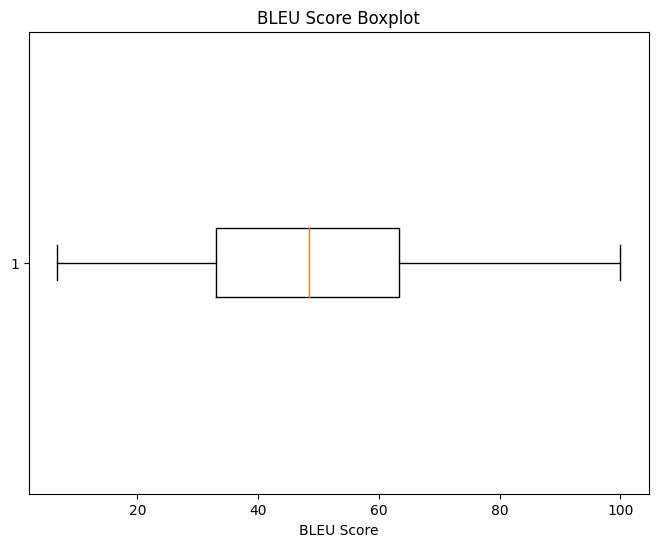

In [10]:
plt.figure(figsize=(8, 6))
plt.boxplot(fr_df['bleu_score'], vert=False)
plt.title('BLEU Score Boxplot')
plt.xlabel('BLEU Score')
plt.show()

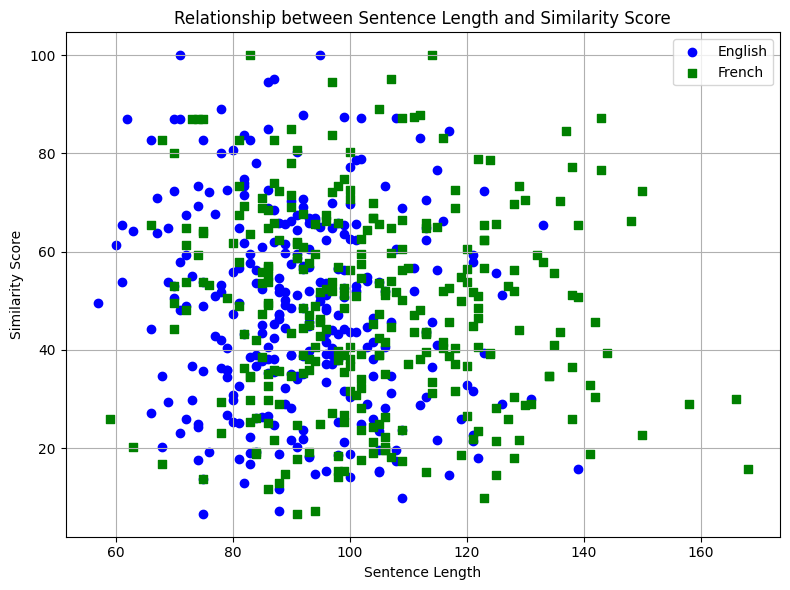

In [11]:
# Calculate length of each sentence
english_lengths = [len(row['English']) for index, row in fr_df.iterrows()]
french_lengths = [len(row['French']) for index, row in fr_df.iterrows()]


plt.figure(figsize=(8, 6))
plt.scatter(english_lengths, fr_df['bleu_score'], label='English', color='blue', marker='o')
plt.scatter(french_lengths, fr_df['bleu_score'], label='French', color='green', marker='s')


plt.xlabel('Sentence Length')
plt.ylabel('Similarity Score')
plt.title('Relationship between Sentence Length and Similarity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Reflection


## Next Steps